<a href="https://colab.research.google.com/github/xmuhammadaziz09/Deeplearnings/blob/main/Tugas2_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import Model
from tensorflow.keras.layers import Resizing, Rescaling
from PIL import Image, ImageChops, ImageEnhance

from pathlib import Path
import os.path
import random
import datetime

import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [3]:
BATCH_SIZE = 35
TARGET_SIZE = (224, 224)
dataset = "/content/drive/MyDrive/Dataset_parfum"

<ipython-input-4-d4b6d27f43d7>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_labels.index, y=top_labels.values, alpha=0.8, palette='dark:salmon_r')


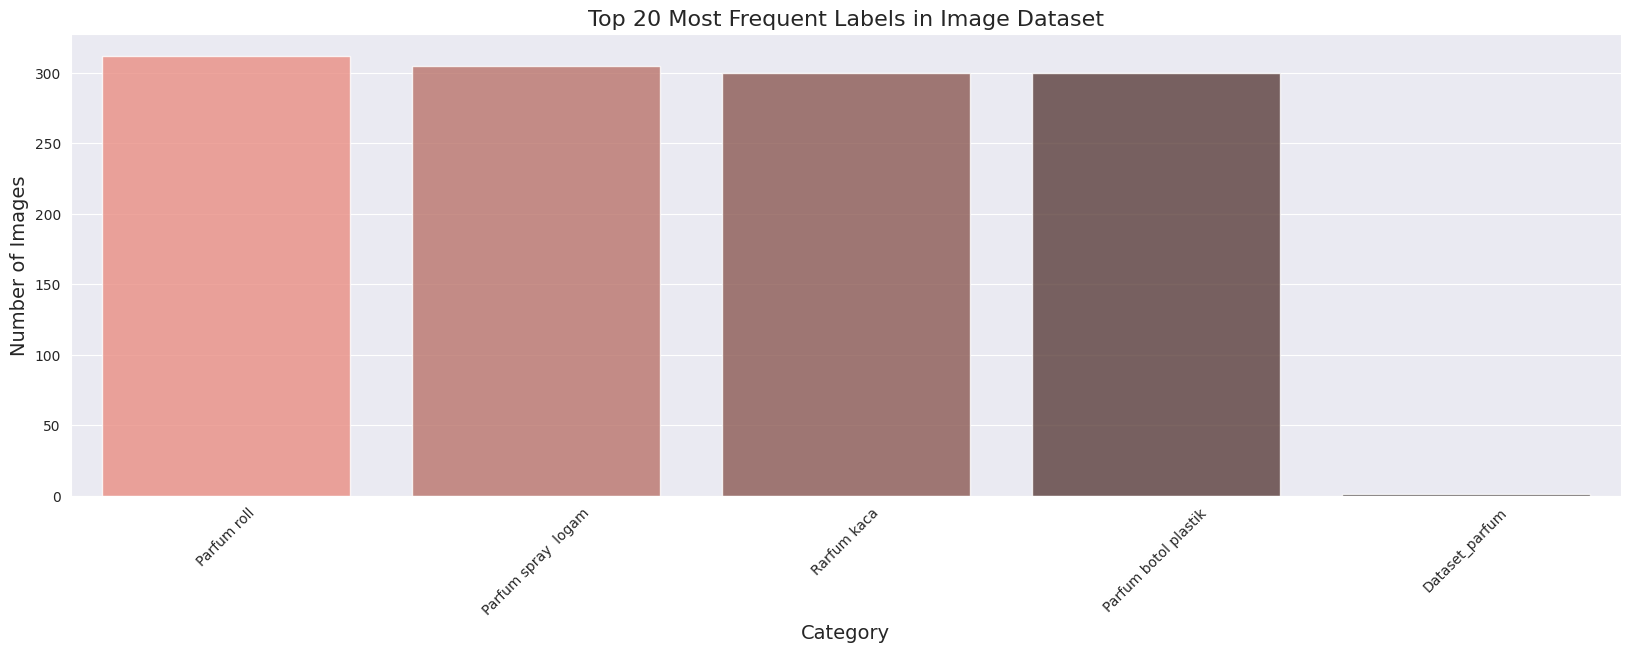

4 folder, 1 file di direktori: /content/drive/MyDrive/Dataset_parfum
0 folder, 300 file di direktori: /content/drive/MyDrive/Dataset_parfum/Rarfum kaca
0 folder, 305 file di direktori: /content/drive/MyDrive/Dataset_parfum/Parfum spray  logam
0 folder, 300 file di direktori: /content/drive/MyDrive/Dataset_parfum/Parfum botol plastik
0 folder, 312 file di direktori: /content/drive/MyDrive/Dataset_parfum/Parfum roll


In [4]:
image_folder = Path(dataset)

# Ambil semua path gambar dengan ekstensi tertentu
image_paths = list(image_folder.glob('**/*.JPG')) + list(image_folder.glob('**/*.jpg')) + \
              list(image_folder.glob('**/*.PNG')) + list(image_folder.glob('**/*.png'))

# Ubah semua ekstensi file menjadi .jpg
for i, path in enumerate(image_paths):
    new_path = path.with_suffix('.jpg')
    if path != new_path:
        path.rename(new_path)
        image_paths[i] = new_path  # update path dalam list

# Ekstrak nama folder sebagai label (diasumsikan label adalah nama folder induk)
image_labels = list(map(lambda path: os.path.split(os.path.split(path)[0])[1], image_paths))

# Ubah ke dalam bentuk Series
image_paths_series = pd.Series(image_paths, name='ImagePath').astype(str)
label_series = pd.Series(image_labels, name='Category')

# Gabungkan path dan label ke dalam satu DataFrame
df_images = pd.concat([image_paths_series, label_series], axis=1)

# Ambil 20 kategori terbanyak berdasarkan jumlah gambar
top_labels = df_images['Category'].value_counts().head(20)

# Visualisasi distribusi 20 label teratas
plt.figure(figsize=(20, 6))
sns.barplot(x=top_labels.index, y=top_labels.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Top 20 Most Frequent Labels in Image Dataset', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45)
plt.show()

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
      print(f"{len(dirnames)} folder, {len(filenames)} file di direktori: {dirpath}")

walk_through_dir(dataset)

<ipython-input-5-3c9f466f234a>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_images = df_images.groupby('Category', group_keys=False).apply(


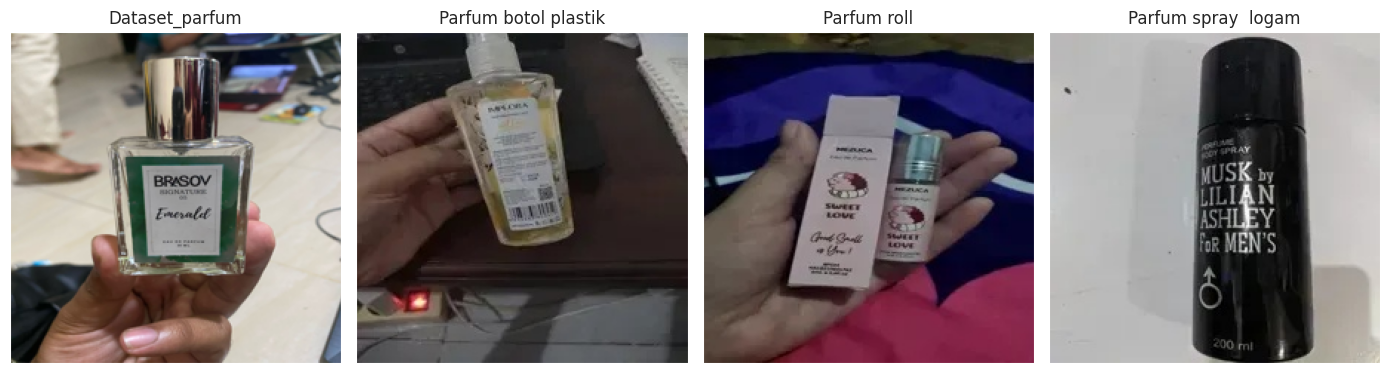

In [5]:
# Ambil satu gambar acak dari setiap kategori (hindari deprecation warning)
sampled_images = df_images.groupby('Category', group_keys=False).apply(
    lambda group: group.sample(1)
).reset_index(drop=True)

# Tentukan jumlah gambar yang ingin ditampilkan (misal: maksimal 8)
num_samples = min(len(sampled_images), 8)

# Setup grid untuk plotting
rows, cols = 1, 4
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 7), subplot_kw={'xticks': [], 'yticks': []})

# Flatten axes dan tampilkan hanya sebanyak `num_samples` gambar
for idx, ax in enumerate(axes.flat[:num_samples]):
    image_path = sampled_images.ImagePath[idx]
    category = sampled_images.Category[idx]

    # Buka gambar dan ubah ukurannya ke bentuk persegi
    image = Image.open(image_path)
    image_square = image.resize((224, 224))

    ax.imshow(image_square)
    ax.set_title(category)

# Sembunyikan sisa subplot jika jumlah gambar < jumlah subplot
for ax in axes.flat[num_samples:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

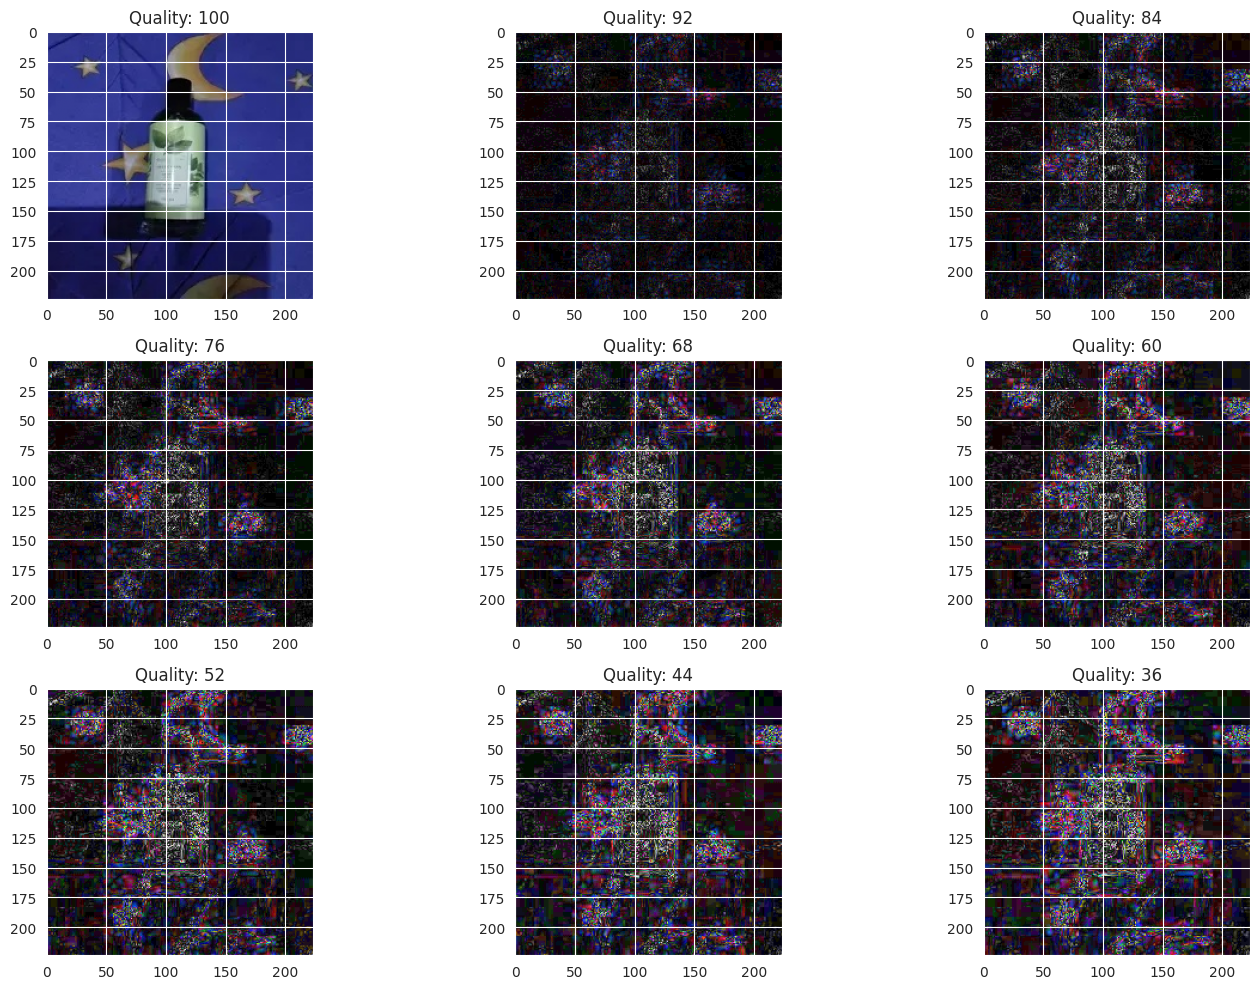

In [6]:
def compute_ela_cv(image_path, compression_quality):
    temp_file = 'temp_file_name.jpeg'
    SCALE_FACTOR = 15
    original = cv2.imread(image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Simpan ulang gambar dengan tingkat kompresi tertentu
    cv2.imwrite(temp_file, original, [cv2.IMWRITE_JPEG_QUALITY, compression_quality])

    # Baca kembali gambar yang sudah dikompresi
    compressed = cv2.imread(temp_file)

    # Hitung perbedaan absolut lalu perbesar nilainya dengan skala
    difference = SCALE_FACTOR * cv2.absdiff(original, compressed)
    return difference


def convert_to_ela_image(image_path, compression_quality):
    temp_jpeg = 'temp_file_name.jpeg'
    temp_ela = 'temp_ela.png'
    original_image = Image.open(image_path).convert('RGB')
    original_image.save(temp_jpeg, 'JPEG', quality=compression_quality)
    recompressed_image = Image.open(temp_jpeg)

    # Hitung selisih piksel antar gambar asli dan hasil kompresi
    ela_result = ImageChops.difference(original_image, recompressed_image)

    max_values = ela_result.getextrema()
    highest_diff = max([val[1] for val in max_values])
    if highest_diff == 0:
        highest_diff = 1

    scale_factor = 255.0 / highest_diff
    ela_result = ImageEnhance.Brightness(ela_result).enhance(scale_factor)

    return ela_result


def select_random_image(folder_path, ext=None):
    # Ambil satu file gambar secara acak dari folder tertentu
    if ext:
        files = Path(folder_path).glob(f'*.{ext}')
    else:
        files = Path(folder_path).glob('*')

    files = list(files)
    selected = random.choice(image_paths)
    return selected.as_posix()


# Ambil satu contoh gambar dari kategori tertentu dan proses menggunakan ELA
selected_class = 'Parfum kaca'
base_path = '/content/drive/MyDrive/Dataset_parfum'
image_path = select_random_image(f'{base_path}/{selected_class}')
original_img = cv2.imread(image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB) / 255.0

# Nilai awal kompresi dan pengaturan grid
start_quality = 100
cols, rows = 3, 3

# Buat plot grid untuk menampilkan hasil
fig = plt.figure(figsize=(15, 10))

for index in range(1, cols * rows + 1):
    compression = start_quality - (index - 1) * 8  # Kurangi kualitas secara bertahap
    ela_output = compute_ela_cv(image_path=image_path, compression_quality=compression)

    if index == 1:
        ela_output = original_img.copy()  # Tampilkan gambar asli di posisi pertama

    resized_img = cv2.resize(ela_output, (224, 224))

    # Tambahkan gambar ke subplot grid
    axis = fig.add_subplot(rows, cols, index)
    axis.title.set_text(f'Quality: {compression}')
    plt.imshow(resized_img)

plt.tight_layout()
plt.show()


In [7]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

# Filter: hanya ambil kelas dengan minimal 2 data
df_images = df_images.groupby('Category').filter(lambda x: len(x) >= 2)

# Split data menjadi train, validation, dan test sets dengan stratifikasi
train_val_df, test_df = train_test_split(
    df_images,
    test_size=0.10,
    shuffle=True,
    random_state=42,
    stratify=df_images['Category']
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=1/3,
    shuffle=True,
    random_state=42,
    stratify=train_val_df['Category']
)

# Tampilkan jumlah data pada masing-masing subset
print(f"Data pelatihan: {len(train_df)}")
print(f"Data validasi: {len(val_df)}")
print(f"Data pengujian: {len(test_df)}")

# Inisialisasi ImageDataGenerator untuk setiap subset data
generator_train = ImageDataGenerator(preprocessing_function=preprocess_input)
generator_val = ImageDataGenerator(preprocessing_function=preprocess_input)
generator_test = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data generator untuk pelatihan
train_flow = generator_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col='Category',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Data generator untuk validasi
val_flow = generator_val.flow_from_dataframe(
    dataframe=val_df,
    x_col='ImagePath',
    y_col='Category',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Data generator untuk pengujian
test_flow = generator_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col='Category',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Data pelatihan: 730
Data validasi: 365
Data pengujian: 122
Found 730 validated image filenames belonging to 4 classes.
Found 365 validated image filenames belonging to 4 classes.
Found 122 validated image filenames belonging to 4 classes.


In [8]:
# Augmentasi Data
augment = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [9]:
# Muat EfficientNetB7 sebagai model dasar
pretrained_model = tf.keras.applications.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'  # Menggunakan global max pooling di akhir
)

# Bekukan bobot dari model pretrained agar tidak dilatih ulang
pretrained_model.trainable = False

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Buat callback untuk menyimpan bobot model terbaik
checkpoint_path = "model_parfum.weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

# Callback untuk menghentikan pelatihan jika val_loss tidak membaik
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Callback untuk mengurangi learning rate jika val_loss stagnan
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Bangun model menggunakan ResNet50 yang telah dimuat sebelumnya
inputs = pretrained_model.input
x = augment(inputs)  # augment dari pipeline augmentasi

x = Dense(64, activation='relu')(pretrained_model.output)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)

outputs = Dense(len(train_flow.class_indices), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fungsi membuat callback TensorBoard
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return TensorBoard(log_dir=log_dir)

# Melatih model
history = model.fit(
    train_flow,
    steps_per_epoch=len(train_flow),
    validation_data=val_flow,
    validation_steps=len(val_flow),
    epochs=55,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "model_parfum"),
        checkpoint_callback,
        reduce_lr
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/55
21/21 ━━━━━━━━━━━━━━━━━━━━ 359s 14s/step - accuracy: 0.2916 - loss: 2.2100 - val_accuracy: 0.3562 - val_loss: 1.3236 - learning_rate: 5.0000e-05
Epoch 2/55
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 512ms/step - accuracy: 0.2598 - loss: 1.6403 - val_accuracy: 0.5014 - val_loss: 1.2825 - learning_rate: 5.0000e-05
Epoch 3/55
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step - accuracy: 0.3026 - loss: 1.3861 - val_accuracy: 0.4849 - val_loss: 1.2884 - learning_rate: 5.0000e-05
Epoch 4/55
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 506ms/step - accuracy: 0.3220 - loss: 1.3679 - val_accuracy: 0.4932 - val_loss: 1.2944 - learning_rate: 5.0000e-05
Epoch 5/55
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - accuracy: 0.3021 - loss: 1.3430 - val_accuracy: 0.4986 - val_loss: 1.2695 - learning_rate: 5.0000e-05
Epoch 6/55
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - accuracy: 0.3484 - loss: 1.3242 - val_accuracy: 0.5452 - val_loss: 1.2356 - learning_rate: 5.0000e-05
Epoch 7/55
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 413ms/step - accurac

In [11]:
# Evaluasi model menggunakan data pengujian
results = model.evaluate(test_flow, verbose=0)

# Menampilkan hasil evaluasi
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.32914
Test Accuracy: 90.98%


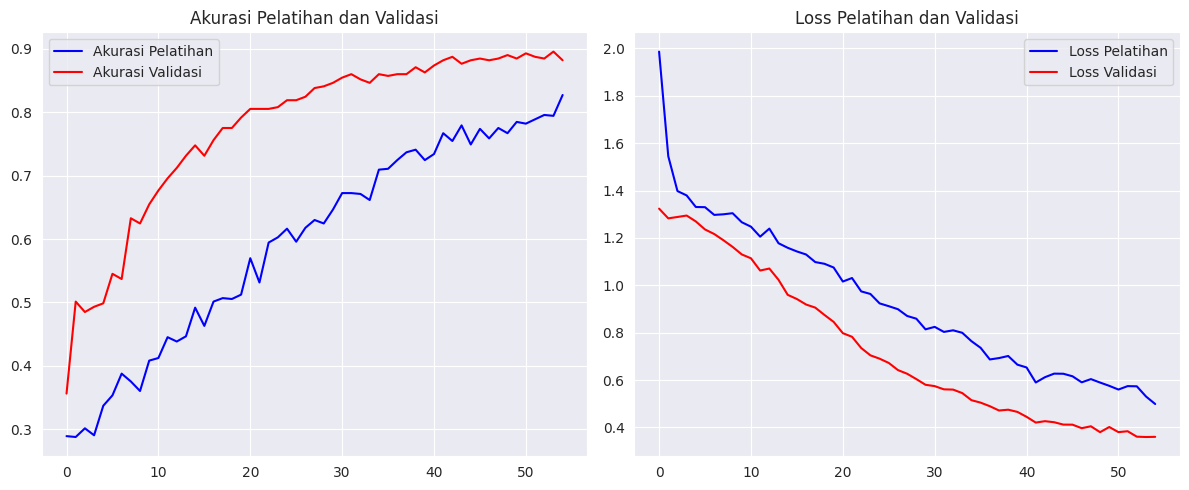

In [12]:
# Ambil data akurasi dan loss dari history pelatihan
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

# Membuat figure dengan 1 baris dan 2 kolom untuk plot
plt.figure(figsize=(12, 5))

# Plot akurasi pelatihan dan validasi
plt.subplot(1, 2, 1)  # 1 baris, 2 kolom, plot pertama
plt.plot(epochs, accuracy, 'b', label='Akurasi Pelatihan')
plt.plot(epochs, val_accuracy, 'r', label='Akurasi Validasi')
plt.title('Akurasi Pelatihan dan Validasi')
plt.legend()

# Plot loss pelatihan dan validasi
plt.subplot(1, 2, 2)  # 1 baris, 2 kolom, plot kedua
plt.plot(epochs, loss, 'b', label='Loss Pelatihan')
plt.plot(epochs, val_loss, 'r', label='Loss Validasi')
plt.title('Loss Pelatihan dan Validasi')
plt.legend()

# Tampilkan plot
plt.tight_layout()
plt.show()

In [13]:
# Lakukan prediksi pada data test
y_pred = model.predict(test_flow)
y_pred_classes = np.argmax(y_pred, axis=1)

# Konversi label ground truth ke format angka (label encoder)
y_true = test_flow.classes

# Ambil label kelas
class_labels = list(test_flow.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step
                      precision    recall  f1-score   support

Parfum botol plastik       0.90      0.90      0.90        30
         Parfum roll       0.97      1.00      0.98        31
 Parfum spray  logam       0.82      0.87      0.84        31
         Rarfum kaca       0.96      0.87      0.91        30

            accuracy                           0.91       122
           macro avg       0.91      0.91      0.91       122
        weighted avg       0.91      0.91      0.91       122



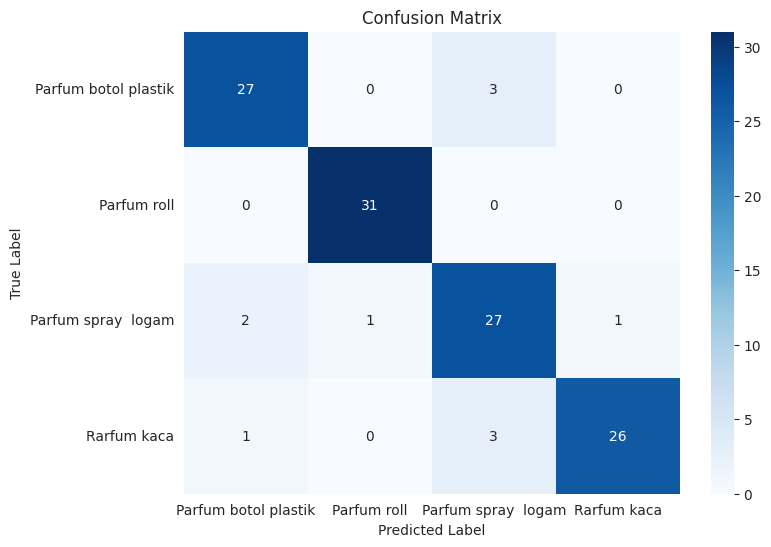

In [14]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


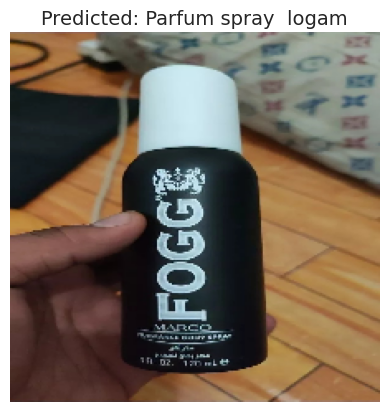

In [19]:
from tensorflow.keras.preprocessing import image

# Fungsi prediksi gambar baru
def predict_new_image(img_path, model, target_size=(224, 224), class_indices=None):
    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimensi

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    # Mapping index ke nama kelas
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class_name = class_labels[predicted_class_index]

    # Tampilkan hasil
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_name}', fontsize=14)
    plt.axis('off')
    plt.show()

# Contoh penggunaan - ganti path dengan gambar barumu
new_image_path = '/content/drive/MyDrive/Dataset_parfum/contoh_parfum.jpg'
predict_new_image(new_image_path, model, target_size=(224, 224), class_indices=test_flow.class_indices)